### Imports

In [216]:
import pandas as pd
import re
import itertools   
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en import English
from booknlp.booknlp import BookNLP
from IPython.core.pylabtools import figsize
sns.set_theme(style="darkgrid")
figsize(20, 15)
pd.set_option('display.max_colwidth', None)
nlp = English()
tokenizer = nlp.tokenizer


### Survey data and stories

In [217]:
def get_indexes(raw):
   if( not pd.isna(raw)):
      highlights = re.findall(r'\d+:', raw)
      return list(map(lambda x: int(x.replace(':', '')) - 1, highlights))

In [218]:
data_unfiltered = pd.read_csv('survey_responses.csv')
data = data_unfiltered
# data = data_unfiltered[(data_unfiltered['aphantasia_check'] == '5') | (data_unfiltered['aphantasia_check'] == '6')]
# data = data_unfiltered[(data_unfiltered['hours_read'] != '0-1 hours')]
data = data.drop(['StartDate', 'ResponseId', 'EndDate', 'IPAddress', 'Progress', 'Duration (in seconds)', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'Q_RecaptchaScore', 'UserLanguage'], axis=1)[data['Finished'] == 'True']
data['highlight_hp_high_1'] = data['highlight_hp_high_1'].map(get_indexes)
data['highlight_hp_high_2'] = data['highlight_hp_high_2'].map(get_indexes)
data['highlight_hp_low_1'] = data['highlight_hp_low_1'].map(get_indexes)
data['highlight_hp_low_2'] = data['highlight_hp_low_2'].map(get_indexes)
data['highlight_hero_high_1'] = data['highlight_hero_high_1'].map(get_indexes)
data['highlight_hero_high_2'] = data['highlight_hero_high_2'].map(get_indexes)
data['highlight_hero_low_1'] = data['highlight_hero_low_1'].map(get_indexes)
data['highlight_hero_low_2'] = data['highlight_hero_low_2'].map(get_indexes)
data

,Status,Finished,RecordedDate,genre,hours_read,read_harry_potter,read_hero_academia,aphantasia_check,highlight_hp_high_1,highlight_hp_high_2,...,highlight_hero_low_2,rate_hero_low_1,rate_hero_low_2,rate_hero_low_3,rate_hero_low_4,rate_hero_low_5,Q61,Q62,Q63,Random ID
1,Survey Preview,True,2022-04-09 18:05:25,sci-fi,2-4 hours,Yes,No,3,"[2, 3, 10, 21, 33, 34]",[28],...,[10],Slightly agree,Slightly agree,Neutral,Slightly disagree,Slightly disagree,somewhat,yes,NaN,2718156370
2,IP Address,True,2022-04-11 14:12:22,Sci-fi short stories,0-1 hours,Yes,No,5,"[1, 13, 21, 23, 33]","[28, 34]",...,"[2, 7, 13]",Slightly disagree,Strongly disagree,Strongly agree,Strongly disagree,Strongly disagree,No,yes,Allow for sub-sentence highlighitng,1170260771
3,IP Address,True,2022-04-15 15:50:12,sci fi,2-4 hours,Yes,No,5,"[0, 11, 21, 26, 33, 34]","[2, 5, 6, 7, 17, 18, 30]",...,"[1, 2, 7, 8, 15]",Slightly disagree,Slightly disagree,Strongly agree,Strongly disagree,Slightly disagree,"It had a slight effect, but not a lot",Yes,NaN,5450760650
4,IP Address,True,2022-04-15 21:20:27,Fantasy,8+ hours,Yes,Yes,5,"[21, 26, 33]","[12, 14, 34]",...,"[4, 10, 20]",Slightly disagree,Slightly disagree,Slightly agree,Slightly disagree,Slightly agree,"A bit, as well as the lack of context for a few of them.",Yes,NaN,4485799558
5,IP Address,True,2022-04-18 07:38:26,fantasy or sci fi,2-4 hours,Yes,No,6,"[0, 11, 26, 33]","[23, 29]",...,"[1, 3, 4, 6, 10, 15, 20]",Slightly agree,Slightly agree,Slightly agree,Slightly agree,Neutral,No,Yes,"There were some formatting issues. Also, I'm afraid I'm so familiar with Harry Potter that it'd be hard not to see the characters or have them feel alive, regardless of the writing style of the passage. So those were harder to judge. But, I enjoyed taking the survey!",5588290680
6,IP Address,True,2022-04-18 08:51:04,Fantasy,0-1 hours,Yes,No,4,[33],[21],...,None,Slightly agree,Slightly agree,Slightly agree,Slightly agree,Strongly agree,No,Yes,NaN,9366543430
7,IP Address,True,2022-04-18 12:37:54,horror,0-1 hours,Yes,No,6,"[2, 7, 10, 13, 14, 21, 33, 34]","[8, 18]",...,[10],Slightly disagree,Neutral,Neutral,Neutral,Slightly disagree,Not sure.,Yes,NaN,7207853888
8,IP Address,True,2022-04-19 19:33:32,reasoning,0-1 hours,Yes,No,5,"[3, 11, 21, 29, 34]","[5, 28]",...,[8],Neutral,Slightly agree,Slightly disagree,Slightly agree,Strongly agree,NaN,NaN,NaN,2909948135
9,IP Address,True,2022-04-23 13:50:32,Sci-fi,2-4 hours,Yes,No,4,"[4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 24, 25, 28, 30, 31, 32, 33, 34]","[0, 1, 2, 3, 5, 6, 7, 8, 9, 22, 23, 26, 27, 29]",...,"[5, 7, 8, 10]",Neutral,Slightly agree,Slightly disagree,Neutral,Slightly agree,A little bit. I had to make myself read the stories first as part of my brain was trying to analyze each sentence in parallel. Probably it would be better if I was asked to read the stories first without knowing why I need to do it.,"Yes. Although I am still not 100% I understood the concept of ""transporting"" correctly. Thus I tried to highlight those sentences that created the most vivid images in my head.",Good luck with your project!,5655762838
10,IP Address,True,2022-04-26 16:19:39,Classic,0-1 hours,Yes,No,6,"[0, 2, 6, 9, 10, 15, 16, 17, 18, 20, 21, 23, 31, 32, 33]","[4, 30]",...,"[2, 14, 15]",Neutral,Slightly agree,Neutral,Slightly agree,Slightly agree,No,Yes,"Not a fan of superhero action stories - possibly that’s why the last one was less engaging. But the third one (even though also about some “heros” was more intriguing. Maybe because it focused more on the thoughts/feelings of a character +had unusual setting, smth unconventional in relation to “hero” stories.",3118759267


In [219]:
hp_high_sentences = list(open('hp_high.txt', 'r').read().split('\n'))
hp_low_sentences = list(open('hp_low.txt', 'r').read().split('\n'))
hero_high_sentences = list(open('hero_high.txt', 'r').read().split('\n'))
hero_low_sentences = list(open('hero_low.txt', 'r').read().split('\n'))


In [220]:
all_stories = ['hp_high', 'hp_low', 'hero_high', 'hero_low']
all_sentences = [hp_high_sentences, hp_low_sentences, hero_high_sentences, hero_low_sentences]

### Utility functions

In [221]:
def group_highlights(sent, highlights, aphantasia):
   highlight_array = np.zeros(len(sent))
   for (x, y) in zip(highlights, aphantasia):
      if(x != None):
         highlight_array[x] += int(y)
   return highlight_array

In [222]:
def get_highlight_text(sent, bool_array):
   return [sent[i] for i in np.where(bool_array)[0]]

In [223]:
def show_highlight_results(storyName, sentences, data):
   column_inc = f"highlight_{storyName}_1"
   column_dec = f"highlight_{storyName}_2"
   y1 = group_highlights(sentences, data[column_inc], data['aphantasia_check'])
   y2 = group_highlights(sentences, data[column_dec], data['aphantasia_check'])

   return (y1, y2)

In [224]:
def get_sentence(num, story):
   story_tokens = tokens[story]
   row = story_tokens[story_tokens['token_ID_within_document'] == num]['sentence_ID']
   if(len(row) > 0):
      return story_tokens[story_tokens['token_ID_within_document'] == num]['sentence_ID'].iloc[0]
   else:
      return -1

In [225]:
def get_supersense(story):
   supersense_df = pd.read_csv(f"results/{story}/{story}.supersense", delimiter='\t')
   story_list = list(itertools.repeat(story, len(supersense_df['start_token'])))
   supersense_df['sentence'] = list(map(get_sentence, supersense_df['start_token'], story_list))
   return supersense_df

In [226]:
def count_cognition_words(supersense, sent):
   cognition_counts = np.zeros(len(sent))
   for i in range(len(sent)):
      supersense_tokens = supersense[supersense['sentence'] == i]['supersense_category']
      for j in supersense_tokens:
         if(j == 'noun.cognition' or j == 'verb.cognition'):
            cognition_counts[i] += 1
   return cognition_counts

In [227]:
def get_concreteness_scores(sentence):
   tokens = tokenizer(sentence)
   score = 0
   for token in tokens:
      row = concreteness_scores[concreteness_scores['Word'] == str(token)]
      if(len(row) > 0):
         score = score + row['Conc.M'].iloc[0]
   return score / len(tokens)

### Process highlights

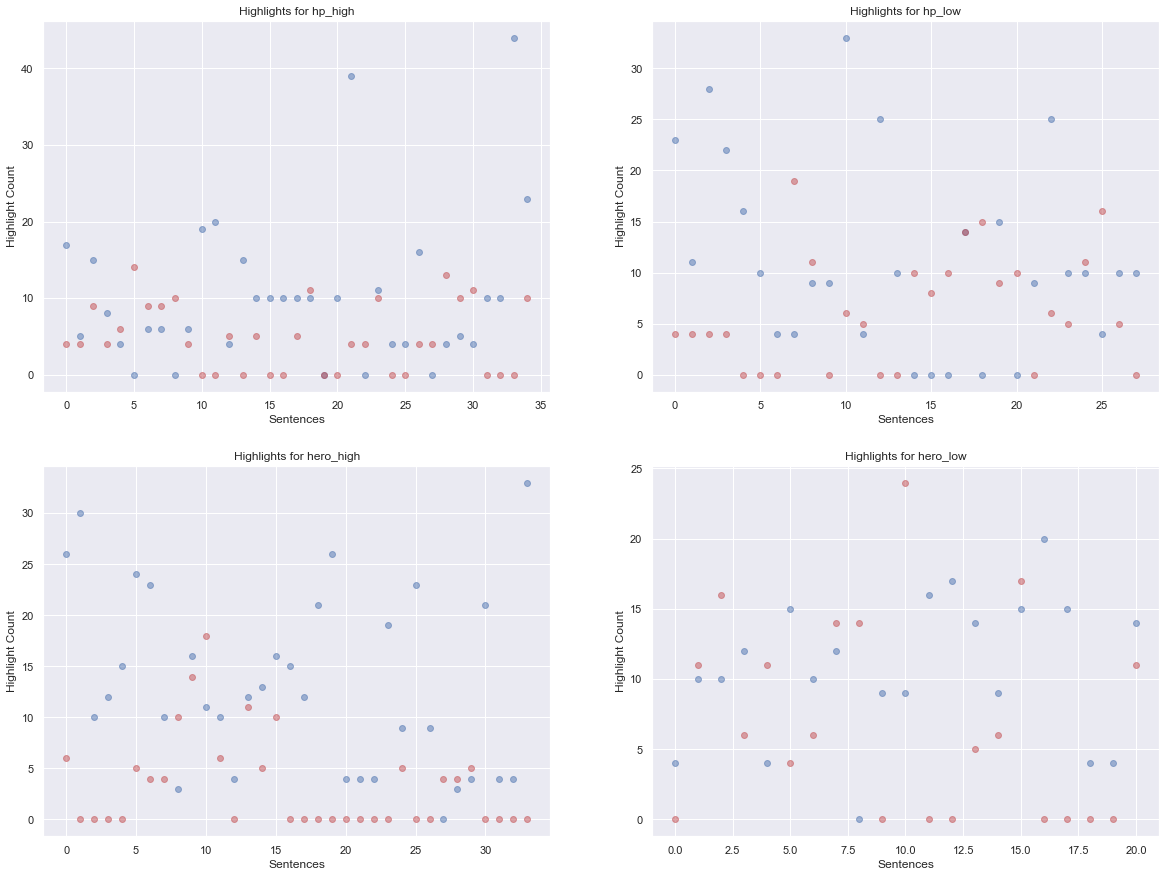

In [228]:
counts_inc = dict(zip(all_stories, np.zeros(len(all_stories))))
counts_dec = dict(zip(all_stories, np.zeros(len(all_stories))))
sentence_counts = dict(zip(all_stories, np.zeros(len(all_stories))))
sentences = dict(zip(all_stories, all_sentences))
fig, ax = plt.subplots(2, 2)
count = 0
axes = [[0, 0], [0, 1], [1, 0], [1, 1]]

for story in all_stories:
   counts_inc[story], counts_dec[story] = show_highlight_results(story, sentences[story], data) # show individual results by passing in a row: data[1:2]
   sentence_counts[story] = pd.DataFrame(sentences[story], columns=['sentence'])
   sentence_counts[story]['increase'] = counts_inc[story]
   sentence_counts[story]['decrease'] = counts_dec[story]
   # display(sentence_counts[story].head())
   # Plot the highlights
   x = np.linspace(0, len(sentences[story]) -1, len(sentences[story]))
   ax1 = axes[count][0]
   ax2 = axes[count][1]
   ax[ax1, ax2].scatter(x, counts_inc[story], alpha=.5, color='b')
   ax[ax1, ax2].scatter(x, counts_dec[story], alpha=.5, color='r')
   ax[ax1, ax2].set_xlabel("Sentences")
   ax[ax1, ax2].set_ylabel("Highlight Count")
   ax[ax1, ax2].set_title(f"Highlights for {all_stories[count]}")

   count +=1
plt.show()


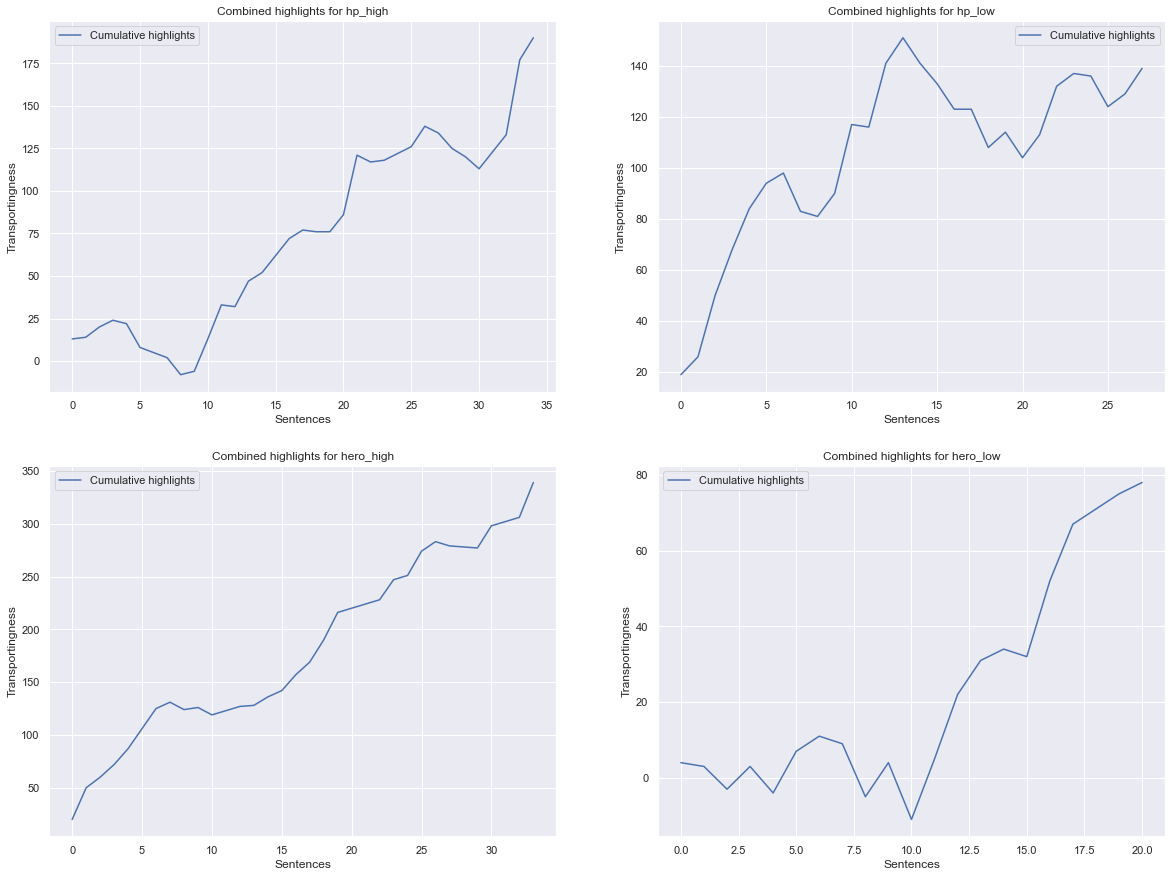

In [229]:


fig, ax = plt.subplots(2, 2)
count = 0
combined_highlights = dict(zip(all_stories, np.zeros(len(all_stories))))

for story in all_stories:
   combined_highlights[story] = counts_inc[story] - counts_dec[story]

   cdf = np.cumsum(combined_highlights[story])
   # Plot the highlights
   x = np.linspace(0, len(sentences[story]) -1, len(sentences[story]))
   ax1 = axes[count][0]
   ax2 = axes[count][1]
   ax[ax1, ax2].plot(x, cdf, color='b', label="Cumulative highlights")
   ax[ax1, ax2].set_xlabel("Sentences")
   ax[ax1, ax2].set_ylabel("Transportingness")
   ax[ax1, ax2].set_title(f"Combined highlights for {all_stories[count]}")
   ax[ax1, ax2].legend()
   count +=1

plt.show()

In [230]:
questions = pd.read_csv('survey_responses.csv')[0:1]

In [231]:
scale_questions = ['emotional_affect', 'forgetting_surroundings', 'distracted', 'characters_alive', 'mental_imagery']

In [232]:
def compute_transportation(story):
   ratings = []
   scale = ['Strongly disagree', 'Slightly disagree', 'Neutral', 'Slightly agree', 'Strongly agree']
   ratings.append(np.round(np.mean(list(map(lambda x: scale.index(x), data[f'rate_{story}_1']))), 2))
   ratings.append(np.round(np.mean(list(map(lambda x: scale.index(x), data[f'rate_{story}_2']))), 2))
   ratings.append(np.round(np.mean(list(map(lambda x: scale.index(x), data[f'rate_{story}_3']))), 2))
   ratings.append(np.round(np.mean(list(map(lambda x: scale.index(x), data[f'rate_{story}_4']))), 2))
   ratings.append(np.round(np.mean(list(map(lambda x: scale.index(x), data[f'rate_{story}_5']))), 2))
   score = ratings[0] + ratings[1] - ratings[2] + ratings[3] + ratings[4]
   return (score, ratings)

In [233]:
# highest possible score: 16
transportation_scores = dict(zip(all_stories, np.zeros(len(all_stories))))
transportation_ratings = dict(zip(all_stories, np.zeros(len(all_stories))))
transportation_ratings_human = dict(zip(all_stories, np.zeros(len(all_stories))))

for story in all_stories:
   transportation_scores[story], transportation_ratings[story] = compute_transportation(story)
   transportation_ratings_human[story] = pd.DataFrame(dict(zip(scale_questions, transportation_ratings[story])).items(), columns=['Question', 'Rating'])
   print(f'Transportation score for {story}: {np.round(transportation_scores[story], 2)}, average ratings:')
   display(transportation_ratings_human[story])

Transportation score for hp_high: 8.3, average ratings:


,Question,Rating
0,emotional_affect,2.1
1,forgetting_surroundings,2.5
2,distracted,2.1
3,characters_alive,3.3
4,mental_imagery,2.5


Transportation score for hp_low: 7.0, average ratings:


,Question,Rating
0,emotional_affect,1.6
1,forgetting_surroundings,2.5
2,distracted,2.2
3,characters_alive,2.4
4,mental_imagery,2.7


Transportation score for hero_high: 8.1, average ratings:


,Question,Rating
0,emotional_affect,2.3
1,forgetting_surroundings,2.6
2,distracted,1.6
3,characters_alive,2.4
4,mental_imagery,2.4


Transportation score for hero_low: 5.6, average ratings:


,Question,Rating
0,emotional_affect,1.9
1,forgetting_surroundings,2.2
2,distracted,2.5
3,characters_alive,1.8
4,mental_imagery,2.2


### BookNLP, LIWC, and Concreteness data

In [234]:
def run_booknlp(story):
	model_params={
			"pipeline":"entity,quote,supersense,event,coref", 
			"model":"big"
		}
		
	booknlp=BookNLP("en", model_params)

	# Input file to process
	input_file=f"{story}.txt"

	# Output directory to store resulting files in
	output_directory=f"results/{story}"

	# File within this directory will be named ${book_id}.entities, ${book_id}.tokens, etc.
	book_id=story

	booknlp.process(input_file, output_directory, book_id)

In [235]:
# for story in all_stories:
#    run_booknlp(story)

In [236]:
concreteness_scores = pd.read_csv("concreteness_scores.csv")
liwc = pd.read_csv('liwc_results.csv')

In [237]:
tokens = dict(zip(all_stories, np.zeros(len(all_stories))))
supersense = dict(zip(all_stories, np.zeros(len(all_stories))))
sentiment = dict(zip(all_stories, np.zeros(len(all_stories))))
pairplot_df = dict(zip(all_stories, np.zeros(len(all_stories))))

for story in all_stories:
   tokens[story] = pd.read_csv(f"results/{story}/{story}.tokens", delimiter='\t')
   supersense[story] = get_supersense(story)
   sentiment[story] = pd.read_csv(f"feature_results/sentiment/{story}_sent.csv")['sentiment']
   sentence_counts[story]['cognition'] = count_cognition_words(supersense[story], sentences[story])
   sentence_counts[story]['perception'] = list(liwc[liwc['Filename'] == f'{story}.txt']['Perception'])
   sentence_counts[story]['concreteness'] = list(map(get_concreteness_scores, sentences[story]))
   sentence_counts[story]['sentiment'] = list(sentiment[story])
   sentence_counts[story]['sentiment_binary'] = list(map(lambda x: 1 if abs(x) > 0 else 0, (sentiment[story])))
   pairplot_df[story] = sentence_counts[story].drop('sentence', axis=1)


<img src="perception.png" width="50%" height="50%">

### Compute Correlations

In [238]:
pairplot_df['hero_high'].head()

,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_binary
0,26.0,6.0,0.0,5.26,1.902174,0.0,0
1,30.0,0.0,0.0,42.11,2.415238,0.0,0
2,10.0,0.0,0.0,0.00,0.911429,1.0,1
3,12.0,0.0,0.0,0.00,1.172000,0.0,0
4,15.0,0.0,0.0,0.00,0.690000,1.0,1


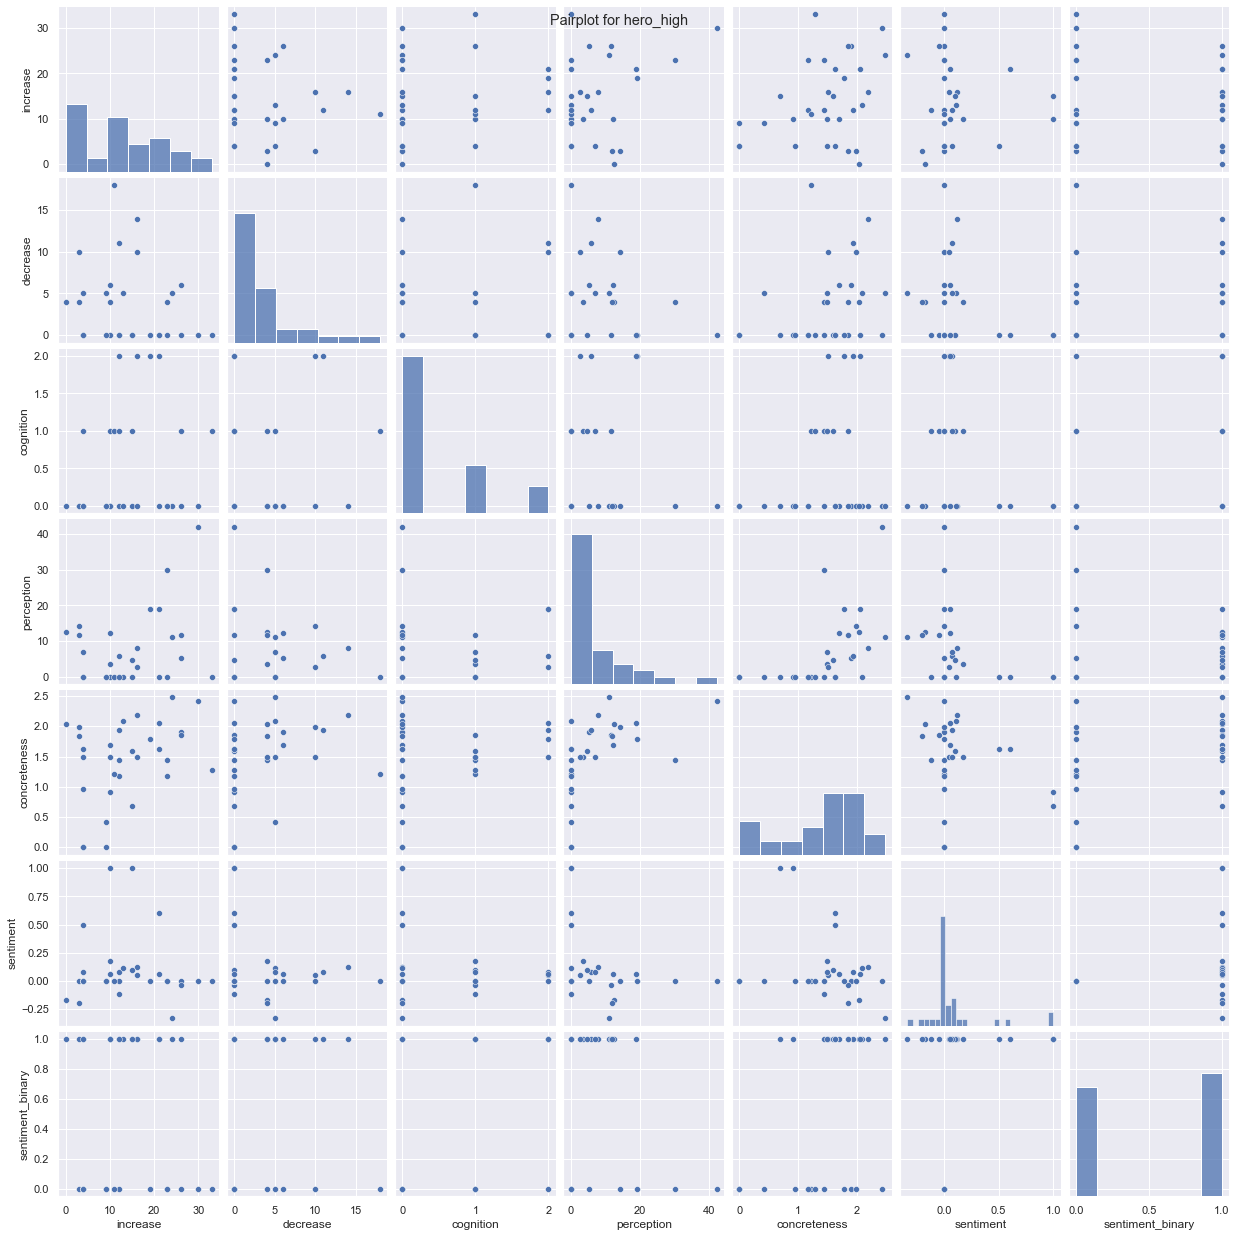

In [239]:
story_pairplot = sns.pairplot(pairplot_df['hero_high'])
story_pairplot.fig.suptitle(f"Pairplot for hero_high")
plt.show()

Correlation for hp_high


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_binary
increase,1.000000,-0.259378,-0.145680,0.177800,0.540631,-0.186053,0.399910
decrease,-0.259378,1.000000,0.019547,0.105325,0.028212,0.118198,0.137933
cognition,-0.145680,0.019547,1.000000,-0.266861,0.115714,0.124353,0.059131
perception,0.177800,0.105325,-0.266861,1.000000,0.172344,0.022707,-0.116453
concreteness,0.540631,0.028212,0.115714,0.172344,1.000000,-0.078300,0.183212
sentiment,-0.186053,0.118198,0.124353,0.022707,-0.078300,1.000000,-0.238119
sentiment_binary,0.399910,0.137933,0.059131,-0.116453,0.183212,-0.238119,1.000000


Correlation for hp_low


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_binary
increase,1.000000,-0.359264,-0.411577,0.192908,0.104246,-0.345550,0.061272
decrease,-0.359264,1.000000,0.120412,-0.400291,0.161911,-0.120561,0.253707
cognition,-0.411577,0.120412,1.000000,-0.244645,-0.003719,0.272251,0.088716
perception,0.192908,-0.400291,-0.244645,1.000000,0.427456,-0.220874,-0.096873
concreteness,0.104246,0.161911,-0.003719,0.427456,1.000000,-0.319147,0.022580
sentiment,-0.345550,-0.120561,0.272251,-0.220874,-0.319147,1.000000,-0.212148
sentiment_binary,0.061272,0.253707,0.088716,-0.096873,0.022580,-0.212148,1.000000


Correlation for hero_high


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_binary
increase,1.000000,-0.085477,0.237703,0.384015,0.432385,-0.019325,-0.042525
decrease,-0.085477,1.000000,0.185116,0.033640,0.344356,-0.187224,0.118702
cognition,0.237703,0.185116,1.000000,0.099706,0.265022,-0.118964,0.259663
perception,0.384015,0.033640,0.099706,1.000000,0.551471,-0.261535,-0.043862
concreteness,0.432385,0.344356,0.265022,0.551471,1.000000,-0.160523,0.495056
sentiment,-0.019325,-0.187224,-0.118964,-0.261535,-0.160523,1.000000,0.307893
sentiment_binary,-0.042525,0.118702,0.259663,-0.043862,0.495056,0.307893,1.000000


Correlation for hero_low


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_binary
increase,1.000000,-0.157187,-0.057147,0.355235,0.444760,-0.320486,0.226837
decrease,-0.157187,1.000000,0.403925,-0.041608,0.255106,0.029664,-0.319237
cognition,-0.057147,0.403925,1.000000,-0.176266,0.126493,-0.058266,-0.118913
perception,0.355235,-0.041608,-0.176266,1.000000,0.350709,-0.228583,-0.032327
concreteness,0.444760,0.255106,0.126493,0.350709,1.000000,-0.036960,0.310537
sentiment,-0.320486,0.029664,-0.058266,-0.228583,-0.036960,1.000000,0.046117
sentiment_binary,0.226837,-0.319237,-0.118913,-0.032327,0.310537,0.046117,1.000000


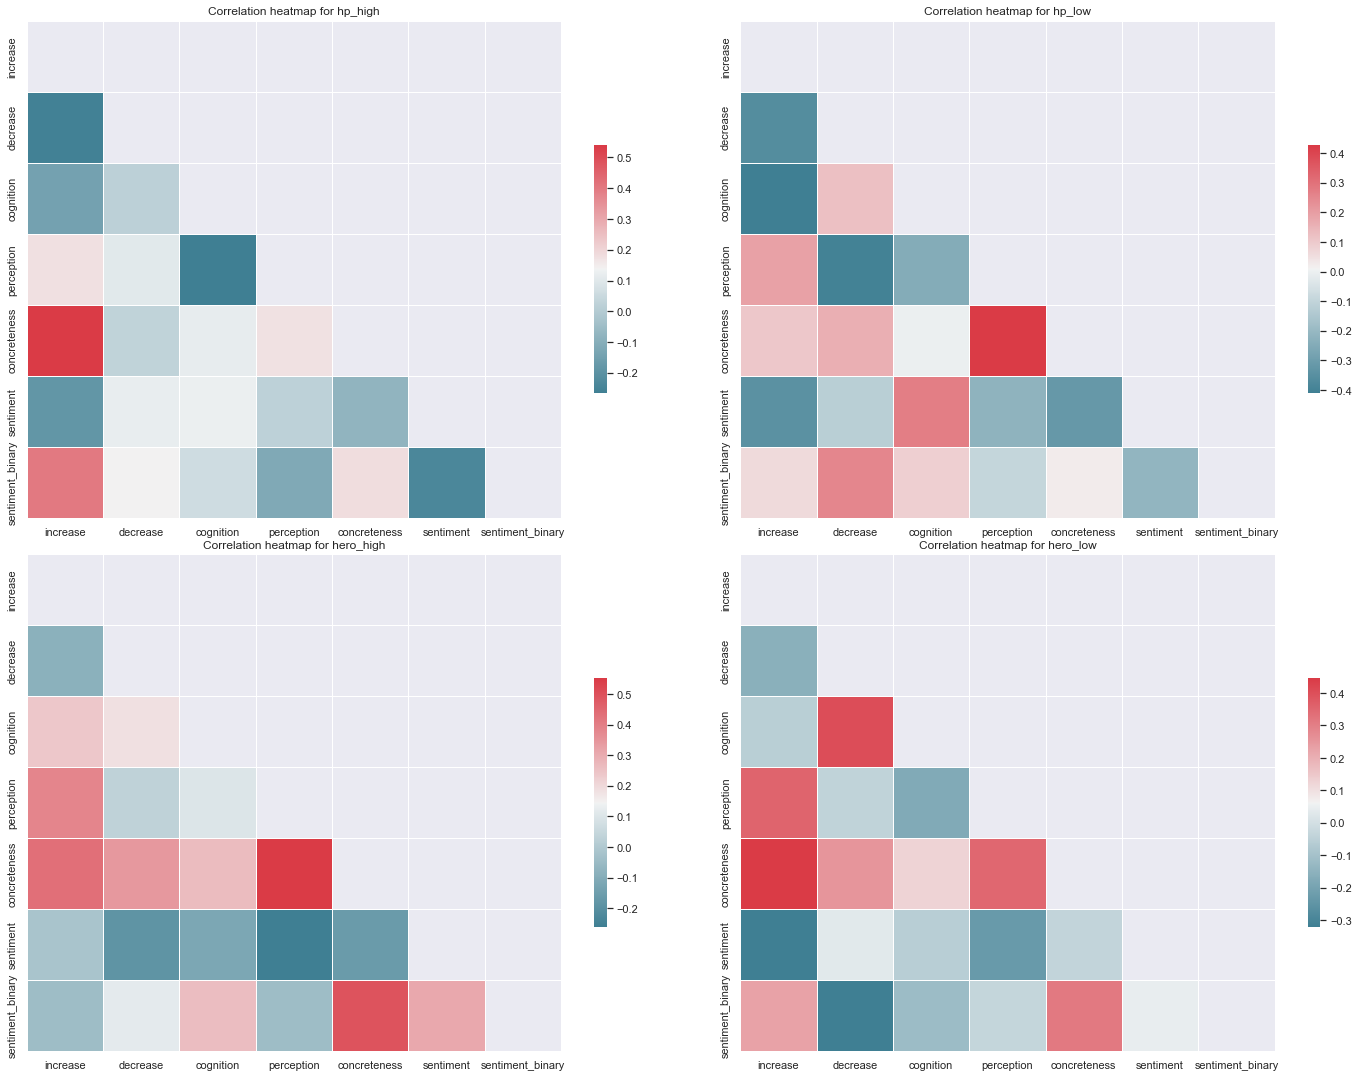

In [240]:
corr = dict(zip(all_stories, np.zeros(len(all_stories))))
f, ax = plt.subplots(2, 2)
count = 0
axes = [[0, 0], [0, 1], [1, 0], [1, 1]]
f.tight_layout()

for story in all_stories:
    ax1 = axes[count][0]
    ax2 = axes[count][1]

    # Compute the correlation matrix
    corr[story] = pairplot_df[story].corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr[story], dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr[story],
        mask=mask,
        cmap=cmap,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        ax=ax[ax1, ax2]
    )
    ax[ax1, ax2].set_title(f"Correlation heatmap for {story}")
    print(f"Correlation for {story}")
    display(corr[story])
    count += 1

plt.show()



,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_binary
increase,1.000000,-0.226203,-0.070833,0.190712,0.348573,-0.117032,0.154083
decrease,-0.226203,1.000000,0.163964,-0.009958,0.251148,-0.104049,0.094856
cognition,-0.070833,0.163964,1.000000,-0.153934,0.161133,0.050126,0.130548
perception,0.190712,-0.009958,-0.153934,1.000000,0.341665,-0.213016,-0.090921
concreteness,0.348573,0.251148,0.161133,0.341665,1.000000,-0.170127,0.339931
sentiment,-0.117032,-0.104049,0.050126,-0.213016,-0.170127,1.000000,0.050302
sentiment_binary,0.154083,0.094856,0.130548,-0.090921,0.339931,0.050302,1.000000


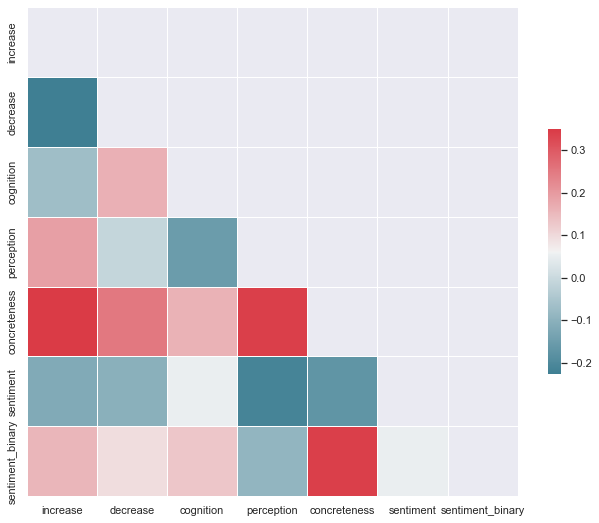

In [242]:
stories_concat = pd.concat([pairplot_df['hero_high'], pairplot_df['hero_low'], pairplot_df['hp_high'], pairplot_df['hp_low']], axis=0)

# Compute the correlation matrix
corr = stories_concat.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(
   corr,
   mask=mask,
   cmap=cmap,
   linewidths=0.5,
   cbar_kws={"shrink": 0.5},
   ax=ax
)
display(corr)

plt.show()